# Genetic Algortihms - III


“It is not the strongest of the species that survives,
not the most intelligent that survives.
It is the one that is the most adaptable to change.”
― Charles Darwin 

# Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





In [ ]:
!pip install pygad

In [ ]:
import pygad
import pygad.nn
import pygad.gann
import pygad.kerasga
import tensorflow
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
print(pygad.__version__)
import numpy as np


2.16.0


# PyGAD

PyGAD is one of the open source python implementations, which provides a simple mean to utilize genetic algorithm in conjuction with other data driven engineering tools. For alternatives, see the additional links at the bottom of the notebook.

The documentation of PyGAD can be accessed from here:

https://pygad.readthedocs.io/en/latest/


There are currently couple of modules that can be called and used:

+ pygad module: instances of the genetic algorithm can be created, run, saved, and loaded 

  https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html

+ The nn module builds artificial neural networks,

  https://pygad.readthedocs.io/en/latest/README_pygad_nn_ReadTheDocs.html

+ The gann module optimizes neural networks (for classification and regression) using the genetic algorithm

  https://pygad.readthedocs.io/en/latest/README_pygad_gann_ReadTheDocs.html

+ The cnn module builds convolutional neural networks,

+ The gacnn module optimizes convolutional neural networks using the genetic algorithm,

+ The kerasga module to train Keras models using the genetic algorithm,

+ The torchga module to train PyTorch models using the genetic algorithm.

## Example: Training a NN for a regression task

The steps to use this project for building and training a neural network using the genetic algorithm are as follows:

+    Prepare the training data.
+    Create an instance of the pygad.gann.GANN class.
+    Fetch the population weights as vectors.
+    Prepare the fitness function.
+    Prepare the generation callback function.
+    Create an instance of the pygad.GA class.
+    Run the created instance of the pygad.GA class.
+    Plot the Fitness Values
+    Information about the best solution.
+    Making predictions using the trained weights.
+    Calculating some statistics.


In [ ]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

In [ ]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

In [ ]:
# Loading the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
new_names = ['frequency','angle_attack','chord_length','Free-stream_velocity','displacement_thickness','sound_pressure']
data = pd.read_csv(url, names=new_names, delimiter='\t')
data.head()

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [ ]:
data.describe()

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


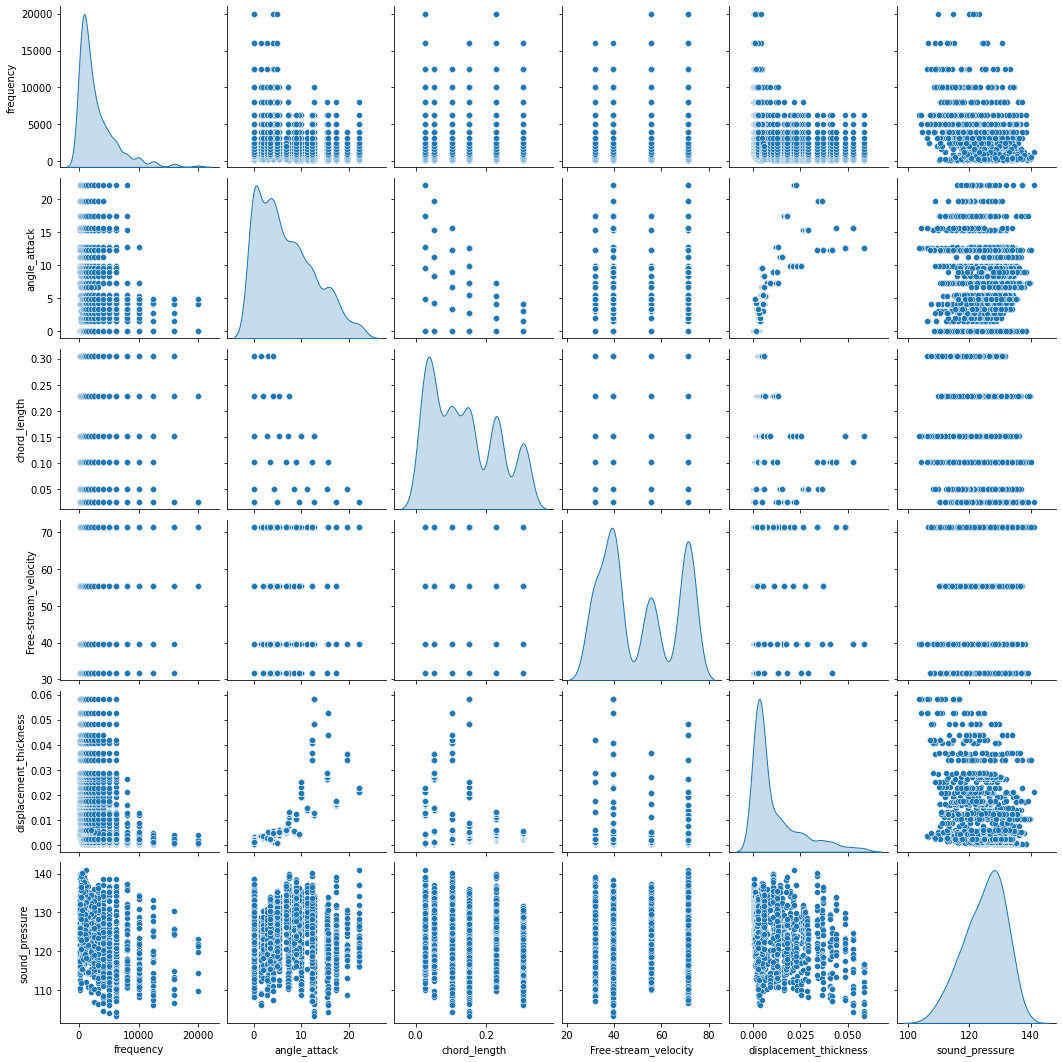

In [ ]:
sns.pairplot(data[['frequency', 'angle_attack','chord_length','Free-stream_velocity','displacement_thickness','sound_pressure']],diag_kind='kde')
sns.set(rc={'figure.figsize':(8,6)})

In [ ]:
dataX = data.copy().drop(['sound_pressure'],axis=1)
dataY = data['sound_pressure'].copy()

In [ ]:
dataY.sample(5)

391     139.918
2       125.951
994     125.127
1197    118.416
1499    109.254
Name: sound_pressure, dtype: float64

In [ ]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness
count,1.503000e+03,1.503000e+03,1.503000e+03,1.503000e+03,1.503000e+03
mean,2.837975e-16,-3.495393e-16,-1.624759e-14,-8.558246e-16,2.866045e-16
std,1.000333e+00,1.000333e+00,1.000333e+00,1.000333e+00,1.000333e+00
min,-8.524068e-01,-1.146403e+00,-1.188629e+00,-1.230809e+00,-8.169263e-01
25%,-6.620227e-01,-8.083458e-01,-9.169992e-01,-7.233448e-01,-6.545613e-01
50%,-4.081773e-01,-2.336486e-01,-3.737395e-01,-7.233448e-01,-4.702979e-01
75%,3.533590e-01,5.269801e-01,9.844097e-01,1.312935e+00,3.374462e-01
max,5.430267e+00,2.606032e+00,1.799299e+00,1.312935e+00,3.595917e+00


In [ ]:
#After the normalization, we need to update the splitted arrays again:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.20, random_state=2020)

The PyGAD library has a module named gann (Genetic Algorithm - Neural Network) that builds an initial population of neural networks using its class named GANN.

In [ ]:
# Preparing the NumPy array of the inputs:
X_train = X_train.to_numpy()
# Preparing the NumPy array of the outputs:
y_train = y_train.to_numpy()

In [ ]:
# The length of the input vector for each sample (i.e. number of neurons in the input layer).
num_inputs = X_train.shape[1]

In [ ]:
def fitness_func(solution, sol_idx):
    global keras_ga, model_nn

    predictions = pygad.kerasga.predict(model=model_nn,
                                        solution=solution,
                                        data=X_train)

    mae = tensorflow.keras.losses.MeanAbsoluteError()
    abs_error = mae(y_train, predictions).numpy() + 0.00000001
    solution_fitness = 1.0/abs_error

    return solution_fitness

In [ ]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [ ]:
# Keras model:

input_layer  = keras.layers.Input((num_inputs,))
x = tensorflow.keras.layers.Dense(16,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(input_layer)
x = tensorflow.keras.layers.Dense(16, activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = tensorflow.keras.layers.Dense(16, activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
output_layer = tensorflow.keras.layers.Dense(1, activation="linear")(x)

model_nn = tensorflow.keras.Model(inputs=input_layer, outputs=output_layer)


In [ ]:
model_nn.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_100 (Dense)            (None, 16)                96        
_________________________________________________________________
dense_101 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_102 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_solutions = 100
keras_ga = pygad.kerasga.KerasGA(model=model_nn, num_solutions=num_solutions)

In [ ]:
# Prepare the PyGAD parameters. Check the documentation for more information: 
#https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_parents_mating = 4 # Number of solutions to be selected as parents in the mating pool.
num_generations = 250 # Number of generations.
mutation_percent_genes = [10,5] # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.
parent_selection_type = "tournament" # Type of parent selection.
crossover_type = "uniform" # Type of the crossover operator.
mutation_type = "adaptive" # Type of the mutation operator.
keep_parents = 4 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
init_range_low = -2
init_range_high = 2
initial_population = keras_ga.population_weights # Initial population of network weights

In [ ]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       mutation_percent_genes=mutation_percent_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       on_generation=callback_generation)

In [ ]:
ga_instance.run()

Generation = 1
Fitness    = 0.008858836156367903
Generation = 2
Fitness    = 0.008858836156367903
Generation = 3
Fitness    = 0.008858836156367903
Generation = 4
Fitness    = 0.009342496304275095
Generation = 5
Fitness    = 0.009342496304275095
Generation = 6
Fitness    = 0.01019014550816296
Generation = 7
Fitness    = 0.011475515900920961
Generation = 8
Fitness    = 0.011874125498943136
Generation = 9
Fitness    = 0.012470073990036959
Generation = 10
Fitness    = 0.012662484672889166
Generation = 11
Fitness    = 0.015511945563768212
Generation = 12
Fitness    = 0.015511945563768212
Generation = 13
Fitness    = 0.016388982247918196
Generation = 14
Fitness    = 0.016388982247918196
Generation = 15
Fitness    = 0.016675926685330373
Generation = 16
Fitness    = 0.017324924210698884
Generation = 17
Fitness    = 0.02071605294530253
Generation = 18
Fitness    = 0.02071605294530253
Generation = 19
Fitness    = 0.02071605294530253
Generation = 20
Fitness    = 0.03186295273156452
Generation = 2

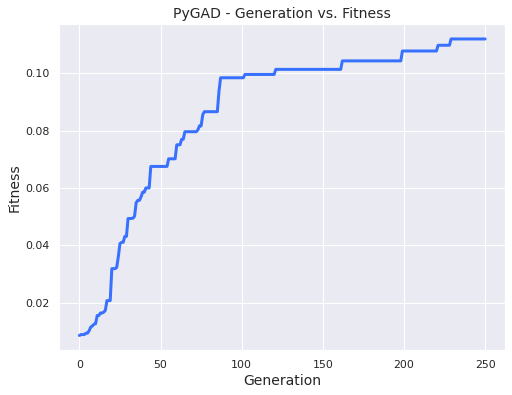

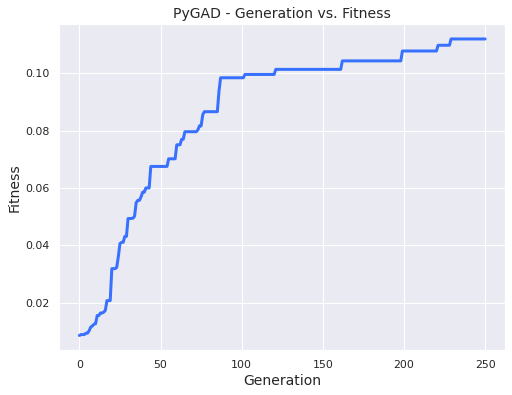

In [ ]:
ga_instance.plot_fitness()

In [ ]:
if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

Best fitness value reached after 229 generations.


### Testing...

In [ ]:
# Preparing the NumPy array of the inputs:
X_test = X_test.to_numpy()
# Preparing the NumPy array of the outputs:
y_test = y_test.to_numpy()

AttributeError: ignored

In [ ]:
# The length of the input vector for each sample (i.e. number of neurons in the input layer).
num_inputs = X_test.shape[1]

In [ ]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

Fitness value of the best solution = 0.11197601599799134
Index of the best solution : 0


In [ ]:
# Make prediction based on the best solution.
predictions = pygad.kerasga.predict(model=model_nn,
                                    solution=solution,
                                    data=X_test)
#print("Predictions : \n", predictions)

mae = tensorflow.keras.losses.MeanAbsoluteError()
abs_error = mae(y_test, predictions).numpy()
print("Absolute Error : ", abs_error)

Absolute Error :  8.747162


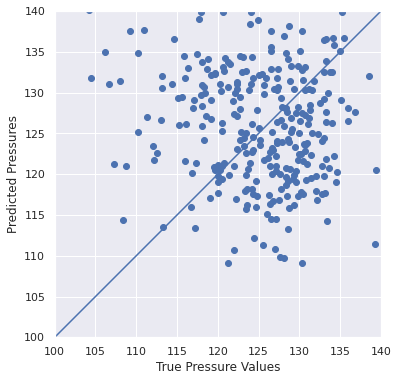

In [ ]:
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, predictions)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [100, 140]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

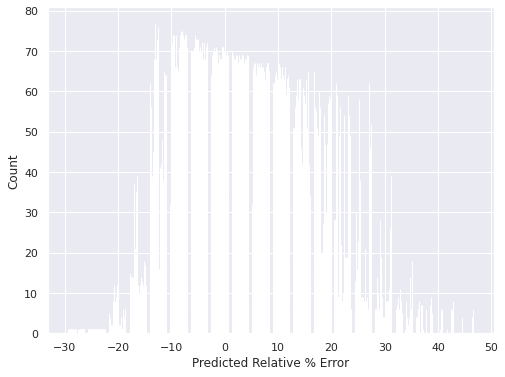

In [ ]:
# Calculating the error variations:
error_nn = (predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')